- Handling warnings

In [76]:
import warnings
warnings.filterwarnings("ignore")

- Loading modules

In [77]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
sns.set_style("whitegrid")
plt.rc('font', size=12)

- Auxiliar functions

In [78]:
def get_metrics(y_true, y_predict, method):
    metrics_estimated = {
        "Method" : method,
        "Accuracy" : accuracy_score(y_true=y_true, y_pred=y_predict),
        "Precision" : precision_score(y_true=y_true, y_pred=y_predict),
        "Recall" : recall_score(y_true=y_true, y_pred=y_predict),
        "F1-score" : f1_score(y_true=y_true, y_pred=y_predict),
        "MCC" : matthews_corrcoef(y_true=y_true, y_pred=y_predict)
    }
    return metrics_estimated

- Preprocessing dataset

In [79]:
df_data = pd.read_csv("../processed_data/1_processed_data.csv")
df_data.head(5)

,ID,Attachment,Gender,IgA D1-Morning,IgA D1-Afternoon,IgA D2-Morning,IgA D2-Afternoon,Average IgA Morning,Average IgA Afternoon,Average Difference IgA
0,1,Insecure,Male,20.076728,31.719207,23.453752,25.016903,21.765240,28.368055,6.602815
1,4,Secure,Male,28.584920,82.400761,28.361209,19.363161,28.473065,50.881961,22.408896
2,5,Secure,Female,161.424693,46.867951,39.006348,52.728307,100.215520,49.798129,-50.417391
3,7,Insecure,Female,26.747838,47.213491,21.599136,35.942378,24.173487,41.577934,17.404447
4,11,NaN,Male,118.901337,47.213491,37.125222,382.715268,78.013279,214.964380,136.951100


In [80]:
df_data.columns

Index(['ID', 'Attachment', 'Gender', 'IgA D1-Morning', 'IgA D1-Afternoon',
       'IgA D2-Morning', 'IgA D2-Afternoon', 'Average IgA Morning',
       'Average IgA Afternoon', 'Average Difference IgA'],
      dtype='object')

In [81]:
df_data = df_data[['Attachment', 'Gender', 'Average IgA Morning',
       'Average IgA Afternoon', 'Average Difference IgA']]
df_data = df_data.dropna()
df_data["Attachment"] = df_data["Attachment"].replace({"Insecure": 1, "Secure":0})
print(df_data.shape)
df_data.head(5)

(27, 5)


,Attachment,Gender,Average IgA Morning,Average IgA Afternoon,Average Difference IgA
0,1,Male,21.765240,28.368055,6.602815
1,0,Male,28.473065,50.881961,22.408896
2,0,Female,100.215520,49.798129,-50.417391
3,1,Female,24.173487,41.577934,17.404447
5,0,Female,29.554870,45.078186,15.523316


In [82]:
response = df_data["Attachment"].values
data_features = df_data.drop(columns=["Attachment"])
data_features["Gender"] = data_features["Gender"].replace({"Female":0, "Male": 1})
data_features.head(5)

,Gender,Average IgA Morning,Average IgA Afternoon,Average Difference IgA
0,1,21.765240,28.368055,6.602815
1,1,28.473065,50.881961,22.408896
2,0,100.215520,49.798129,-50.417391
3,0,24.173487,41.577934,17.404447
5,0,29.554870,45.078186,15.523316


- Apply standardization process

In [83]:
scaler_instance = MinMaxScaler()
scaler_instance.fit(data_features.values)
scaled_data = scaler_instance.transform(data_features.values)

df_prepared = pd.DataFrame(data=scaled_data, columns=data_features.columns)
df_prepared["Attachment"] = response
df_prepared.head(5)

,Gender,Average IgA Morning,Average IgA Afternoon,Average Difference IgA,Attachment
0,1.0,0.068661,0.106902,0.485103,1
1,1.0,0.148294,0.396818,0.619574,0
2,0.0,1.000000,0.382861,0.000000,0
3,0.0,0.097251,0.277008,0.576998,1
4,0.0,0.161137,0.322081,0.560995,0


- Using SMOTE for data augmentation

In [84]:
X = df_prepared.drop(columns=['Attachment'])
y = df_prepared['Attachment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print(y_test.shape, y_train.shape)

(9,) (18,)


- 300 per class will be generated

In [85]:
smote = SMOTE(
    random_state=42,
    sampling_strategy={1: 100, 0: 100})

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled["Gender"] = X_train_resampled["Gender"].apply(lambda x: 1 if x > 0.5 else 0)

In [86]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.3, stratify=y_train_resampled, random_state=42
)

In [87]:
X_train.head()

,Gender,Average IgA Morning,Average IgA Afternoon,Average Difference IgA
0,0,1.000000,0.382861,0.000000
148,0,0.077955,0.327275,0.624036
141,0,0.129271,0.067092,0.415367
87,1,0.156984,0.220778,0.497043
188,0,0.147316,0.079544,0.410662


In [88]:
X_val.head()

,Gender,Average IgA Morning,Average IgA Afternoon,Average Difference IgA
107,1,0.170332,0.972836,0.984339
20,0,0.264344,0.163742,0.382425
106,0,0.089718,0.057088,0.437103
136,1,0.115415,0.012387,0.389155
133,0,0.158741,0.055325,0.386474


- Training models

In [89]:
lr_model = LogisticRegression(random_state=42).fit(X=X_train_resampled, y=y_train_resampled)
knn_model = KNeighborsClassifier().fit(X=X_train_resampled, y=y_train_resampled)
dt_model = DecisionTreeClassifier(random_state=42).fit(X=X_train_resampled, y=y_train_resampled)
rf_model = RandomForestClassifier(random_state=42).fit(X=X_train_resampled, y=y_train_resampled)

- Make predictions and get metrics

In [90]:
lr_predictions_val = lr_model.predict(X=X_val)
lr_predictions_test = lr_model.predict(X=X_test)

lr_performances_val = get_metrics(y_true=y_val, y_predict=lr_predictions_val, method="LogisticRegression")
lr_performances_test = get_metrics(y_true=y_test, y_predict=lr_predictions_test, method="LogisticRegression")


In [91]:
knn_predictions_val = knn_model.predict(X=X_val)
knn_predictions_test = knn_model.predict(X=X_test)

knn_performances_val = get_metrics(y_true=y_val, y_predict=knn_predictions_val, method="KNN")
knn_performances_test = get_metrics(y_true=y_test, y_predict=knn_predictions_test, method="KNN")

In [92]:
dt_predictions_val = dt_model.predict(X=X_val)
dt_predictions_test = dt_model.predict(X=X_test)

dt_performances_val = get_metrics(y_true=y_val, y_predict=dt_predictions_val, method="Decision Tree")
dt_performances_test = get_metrics(y_true=y_test, y_predict=dt_predictions_test, method="Decision Tree")

In [93]:
rf_predictions_val = rf_model.predict(X=X_val)
rf_predictions_test = rf_model.predict(X=X_test)

rf_performances_val = get_metrics(y_true=y_val, y_predict=rf_predictions_val, method="Random Forest")
rf_performances_test = get_metrics(y_true=y_test, y_predict=rf_predictions_test, method="Random Forest")

- Making summary of performances

In [94]:
data_performances_val = [
    lr_performances_val,
    knn_performances_val,
    dt_performances_val,
    rf_performances_val
]

df_perfomances_val = pd.DataFrame(data_performances_val)
df_perfomances_val

,Method,Accuracy,Precision,Recall,F1-score,MCC
0,LogisticRegression,0.666667,0.638889,0.766667,0.69697,0.340207
1,KNN,0.950000,0.935484,0.966667,0.95082,0.900500
2,Decision Tree,1.000000,1.000000,1.000000,1.00000,1.000000
3,Random Forest,1.000000,1.000000,1.000000,1.00000,1.000000


In [95]:
data_performances_test = [
    lr_performances_test,
    knn_performances_test,
    dt_performances_test,
    rf_performances_test
]

df_perfomances_test = pd.DataFrame(data_performances_test)
df_perfomances_test

,Method,Accuracy,Precision,Recall,F1-score,MCC
0,LogisticRegression,0.666667,0.500000,0.666667,0.571429,0.316228
1,KNN,0.666667,0.500000,0.666667,0.571429,0.316228
2,Decision Tree,0.777778,0.666667,0.666667,0.666667,0.500000
3,Random Forest,0.777778,0.666667,0.666667,0.666667,0.500000


- Making analyzis based on classification model. In this case, we only will select the Decision tree and the Random Forest models

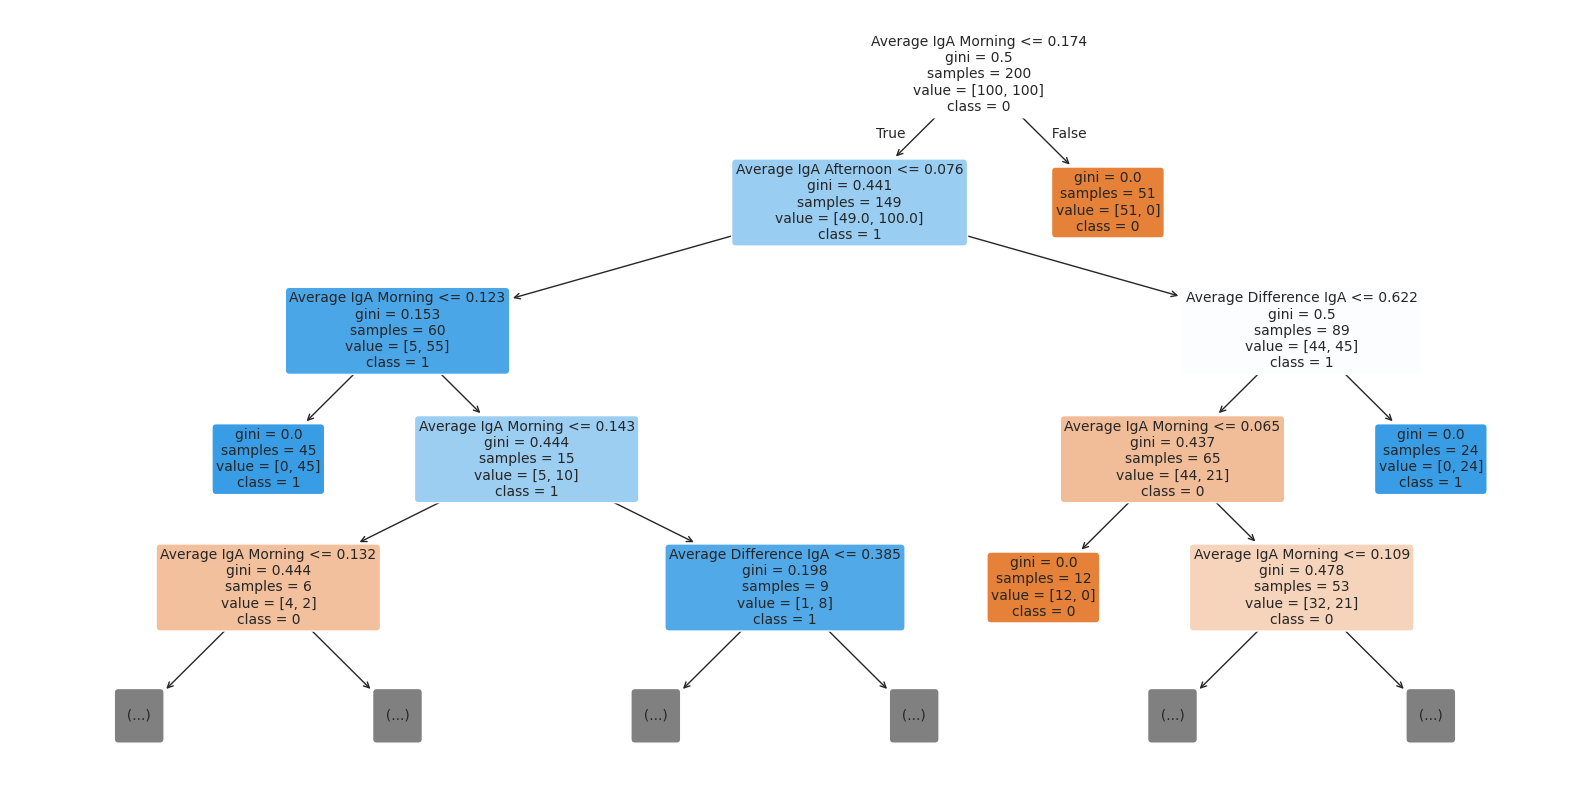

In [96]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=[str(c) for c in dt_model.classes_],
    filled=True,
    rounded=True,
    max_depth=4,
    fontsize=10
)

plt.show()

- Feature relevance Random Forest

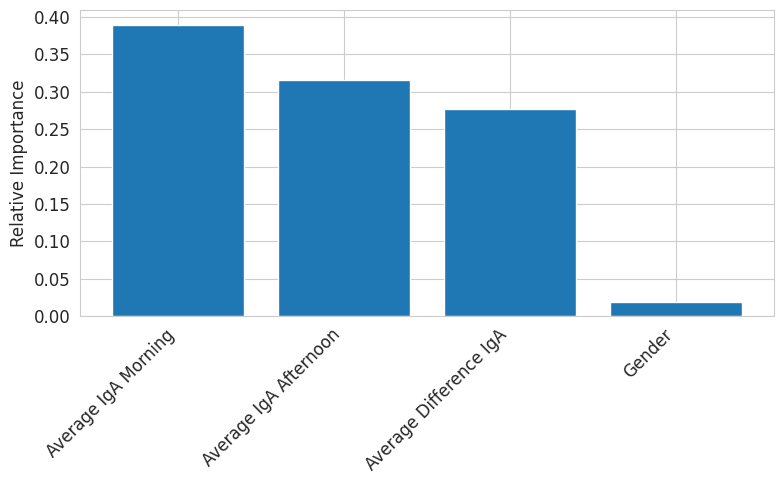

In [97]:
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45, ha='right')
plt.ylabel("Relative Importance")
plt.tight_layout()
plt.show()

- SHAP analysis